<a href="https://colab.research.google.com/github/palakagl/AI-in-Finance/blob/main/Stock_Price_Prediction_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Long Short Term Memory 
## Stock Price Predicton 

Import the libraries

In [1]:
!pip install yfinance --upgrade --no-cache-dir

     |████████████████████████████████| 63 kB 8.3 MB/s 
     |████████████████████████████████| 6.4 MB 44.7 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [2]:
!pip install --upgrade pandas
!pip install --upgrade pandas-datareader

     |████████████████████████████████| 109 kB 5.1 MB/s 
  Attempting uninstall: pandas-datareader
    Found existing installation: pandas-datareader 0.9.0
    Uninstalling pandas-datareader-0.9.0:
      Successfully uninstalled pandas-datareader-0.9.0


In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import os


import math
import yfinance as yf

import pandas_datareader as web
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

Download the data from yahoo. 

In [4]:
df=web.DataReader('TSLA', 'yahoo', start='2012-01-01', end='2022-03-20')

df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-01-03,5.900000,5.530000,5.788000,5.616000,4640500.0,5.616000
2012-01-04,5.734000,5.500000,5.642000,5.542000,3150500.0,5.542000
2012-01-05,5.586000,5.370000,5.552000,5.424000,5027500.0,5.424000
2012-01-06,5.558000,5.282000,5.440000,5.382000,4931500.0,5.382000
2012-01-09,5.498000,5.224000,5.400000,5.450000,4485000.0,5.450000
...,...,...,...,...,...,...
2022-03-14,800.700012,756.039978,780.609985,766.369995,23717400.0,766.369995
2022-03-15,805.570007,756.570007,775.270020,801.890015,22280400.0,801.890015
2022-03-16,842.000000,802.260010,809.000000,840.229980,28009600.0,840.229980


In [5]:
df.shape

(2570, 6)

Visualize

Text(0, 0.5, 'Stock Price ($)')

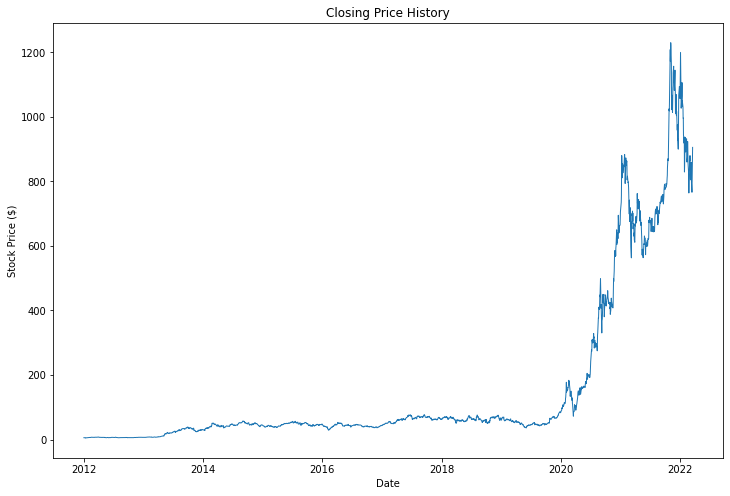

In [6]:
plt.figure(figsize=(12,8))
plt.title('Closing Price History')
plt.plot(df['Close'], lw=1)
plt.xlabel('Date')
plt.ylabel('Stock Price ($)')

In [7]:
data=df.filter(['Close'])

Prepare the data

In [8]:
#convert to numpy array
#We are going to split the data into 80:20 ration for training and testing
train_pct=0.8  
dataset=data.values
train_data_len=math.ceil(len(dataset)*train_pct)

In [9]:
dataset

array([[  5.61600018],
       [  5.54199982],
       [  5.42399979],
       ...,
       [840.22998047],
       [871.59997559],
       [905.39001465]])

In [10]:
dataset.shape

(2570, 1)

In [11]:
#Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(dataset)

In [12]:
scaled_data

array([[8.63425414e-04],
       [8.03034313e-04],
       [7.06735432e-04],
       ...,
       [6.81985223e-01],
       [7.07586025e-01],
       [7.35161806e-01]])

Time Period to predict the Stock price

In [13]:
n_period=60
week = 5
#training dataset
train_data=scaled_data[0:train_data_len]
x_train=[]
y_train=[]

for i in range(n_period, len(train_data)):
    x_train.append(train_data[i-n_period:i,0])
    y_train.append(train_data[i,0])
   #y_train.append(train_data[i+week:-week,0])

In [14]:
x_train[0:2]

[array([0.00086343, 0.00080303, 0.00070674, 0.00067246, 0.00072795,
        0.00078834, 0.00088791, 0.00089117, 0.        , 0.00062186,
        0.00065614, 0.00064798, 0.00062186, 0.00064961, 0.0007557 ,
        0.00084547, 0.00100379, 0.00106745, 0.00110662, 0.00102501,
        0.00110825, 0.00121761, 0.00136451, 0.0014706 , 0.00143795,
        0.00149182, 0.00159791, 0.00135634, 0.00142   , 0.00169421,
        0.00176439, 0.00185906, 0.001988  , 0.00191129, 0.00186559,
        0.00191618, 0.00178887, 0.00176766, 0.00179867, 0.00173338,
        0.0018966 , 0.00183621, 0.00179214, 0.00168441, 0.00168605,
        0.00167788, 0.00195046, 0.00215775, 0.0021708 , 0.00204023,
        0.0019929 , 0.00204513, 0.00198963, 0.00198637, 0.00201738,
        0.00189497, 0.00184274, 0.00238462, 0.00247276, 0.00245807]),
 array([0.00080303, 0.00070674, 0.00067246, 0.00072795, 0.00078834,
        0.00088791, 0.00089117, 0.        , 0.00062186, 0.00065614,
        0.00064798, 0.00062186, 0.00064961, 0.

In [15]:
y_train[0:2]

[0.0023731955482700017, 0.002358505789421763]

In [16]:
#Convert numpy array
x_train, y_train=np.array(x_train), np.array(y_train)

In [17]:
x_train.shape

(1996, 60)

In [18]:
x_train=np.reshape(x_train, (x_train.shape[0], x_train.shape[1],1))
x_train.shape

(1996, 60, 1)

Training the model with Adam optimization (It is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.) 
For Loss function, we are using mean_squared_error

In [19]:
#Build the LSTM model
model=Sequential()
model.add(LSTM(50,return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [20]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [21]:
model.fit(x_train,y_train, batch_size=1, epochs=5)

Epoch 1/5
1996/1996 [==============================] - 120s 52ms/step - loss: 4.9084e-05
Epoch 2/5
1996/1996 [==============================] - 60s 30ms/step - loss: 2.6640e-05
Epoch 3/5
1996/1996 [==============================] - 59s 30ms/step - loss: 1.3983e-05
Epoch 4/5
1996/1996 [==============================] - 60s 30ms/step - loss: 1.7776e-05
Epoch 5/5
1996/1996 [==============================] - 60s 30ms/step - loss: 1.0947e-05


In [22]:
#Test
test_data=scaled_data[train_data_len-60:,:]
x_test=[]
y_test=dataset[train_data_len:,:]

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i,0])
    
               
x_test=np.array(x_test)
x_test=np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [23]:
x_test.shape

(514, 60, 1)

Prediction error

In [24]:
predictions=model.predict(x_test)

In [25]:
predictions=scaler.inverse_transform(predictions)

In [26]:
predictions.shape

(514, 1)

In [27]:
#RMSE
rmse=np.sqrt(np.mean(predictions-y_test)**2)
rmse

28.28154071852391

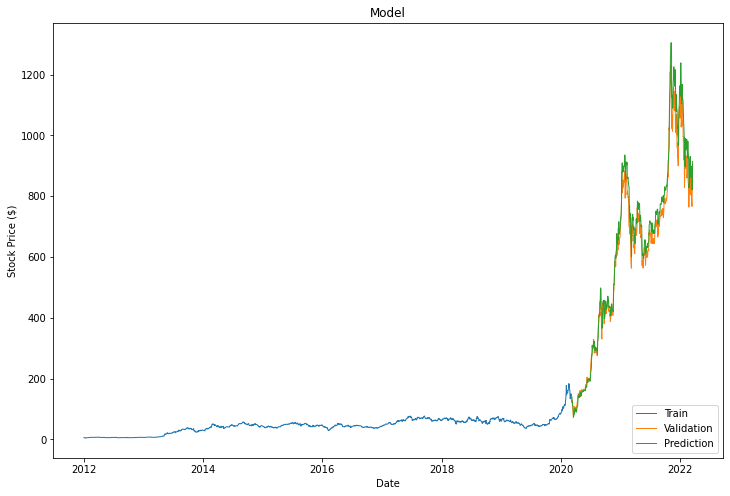

In [28]:
#plot the result
train=data[:train_data_len]
valid=data[train_data_len:]
valid=valid.assign(Predictions=predictions)
plt.figure(figsize=(12,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Stock Price ($)')
plt.plot(train['Close'], lw=1)
plt.plot(valid[['Close','Predictions']], lw=1)
plt.legend(['Train','Validation', 'Prediction'],loc='lower right')
plt.show()

In [29]:
valid

,Close,Predictions
Date,,
2020-03-06,140.695999,143.833679
2020-03-09,121.599998,139.341797
2020-03-10,129.065994,124.936699
2020-03-11,126.846001,124.246445
2020-03-12,112.110001,123.790909
...,...,...
2022-03-14,766.369995,858.108459
2022-03-15,801.890015,821.520630
2022-03-16,840.229980,837.521484


In [30]:
#get the quote
quote=web.DataReader('TSLA', 'yahoo', '2021-12-01', '2022-03-29')

In [31]:
quote

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2021-12-01,1172.839966,1090.760010,1160.699951,1095.000000,22816800,1095.000000
2021-12-02,1113.000000,1056.650024,1099.060059,1084.599976,24371600,1084.599976
2021-12-03,1090.579956,1000.210022,1084.790039,1014.969971,30774000,1014.969971
2021-12-06,1021.640015,950.500000,1001.510010,1009.010010,27221000,1009.010010
2021-12-07,1057.670044,1026.810059,1044.199951,1051.750000,18694900,1051.750000
...,...,...,...,...,...,...
2022-03-23,1040.699951,976.400024,979.940002,999.109985,40225400,999.109985
2022-03-24,1024.489990,988.799988,1009.729980,1013.919983,22973600,1013.919983
2022-03-25,1021.799988,997.320007,1008.000000,1010.640015,20677200,1010.640015


In [32]:
quote_df=quote.filter(['Close'])

In [33]:
quote_df.shape

(82, 1)

In [34]:
quote_df

,Close
Date,
2021-12-01,1095.000000
2021-12-02,1084.599976
2021-12-03,1014.969971
2021-12-06,1009.010010
2021-12-07,1051.750000
...,...
2022-03-23,999.109985
2022-03-24,1013.919983
2022-03-25,1010.640015


In [35]:
quote_df.tail(10)

,Close
Date,
2022-03-16,840.229980
2022-03-17,871.599976
2022-03-18,905.390015
2022-03-21,921.159973
2022-03-22,993.979980
2022-03-23,999.109985
2022-03-24,1013.919983
2022-03-25,1010.640015
2022-03-28,1091.839966


In [36]:
#last 60 days
last_60_days=quote_df.values
#last_60_days
last_60_days_scaled=scaler.transform(last_60_days)


In [37]:
last_60_days_scaled.shape

(82, 1)

In [38]:
X_test=[]

for i in range(60, len(last_60_days_scaled)):
  X_test.append(last_60_days_scaled[i-60:i,0])

In [39]:
X_test=np.array(X_test)
X_test=np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))

In [40]:
X_test.shape

(22, 60, 1)

In [41]:
predicted_price=model.predict(X_test)
predicted_prce=scaler.inverse_transform(predicted_price)
predicted_prce.shape

(22, 1)

In [90]:
print(predicted_prce)

[[ 853.6166 ]
 [ 905.01276]
 [ 918.70654]
 [ 930.5008 ]
 [ 902.2207 ]
 [ 889.18146]
 [ 861.2037 ]
 [ 867.19617]
 [ 898.8101 ]
 [ 895.2504 ]
 [ 858.10846]
 [ 821.52057]
 [ 837.5215 ]
 [ 876.4006 ]
 [ 914.254  ]
 [ 950.97736]
 [ 973.3931 ]
 [1033.6222 ]
 [1059.0457 ]
 [1074.7388 ]
 [1075.9928 ]
 [1136.6187 ]]


In [93]:
predicted_prce_df = pd.DataFrame(predicted_prce, columns=['Predicted Price'])
predicted_prce_df = predicted_prce_df[-5:]
predicted_prce_df

,Predicted Price
17,1033.622192
18,1059.045654
19,1074.738770
20,1075.992798
21,1136.618652


In [94]:
#get the quote
actual_price = web.DataReader('TSLA', 'yahoo', '2022-03-23', '2022-03-29')
actual_price

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2022-03-23,1040.699951,976.400024,979.940002,999.109985,40225400,999.109985
2022-03-24,1024.489990,988.799988,1009.729980,1013.919983,22973600,1013.919983
2022-03-25,1021.799988,997.320007,1008.000000,1010.640015,20677200,1010.640015
2022-03-28,1097.880005,1053.599976,1065.099976,1091.839966,34168700,1091.839966
2022-03-29,1114.770020,1073.109985,1107.989990,1099.569946,24538300,1099.569946


In [95]:
price_diff = actual_price.filter(['Close'])
price_diff["Predicted Price"] = pd.NaT
price_diff["Predicted Price"] = np.array(predicted_prce_df)
price_diff["Price Difference"] = pd.NaT
price_diff["Price Difference"] = price_diff["Predicted Price"] - price_diff["Close"]

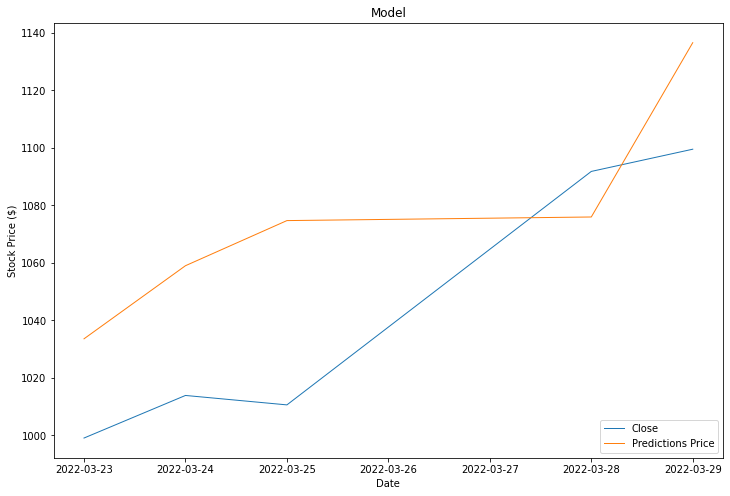

In [96]:
plt.figure(figsize=(12,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Stock Price ($)')
plt.plot(price_diff[['Close','Predicted Price']], lw=1)
plt.legend(['Close','Predictions Price'],loc='lower right')
plt.show()

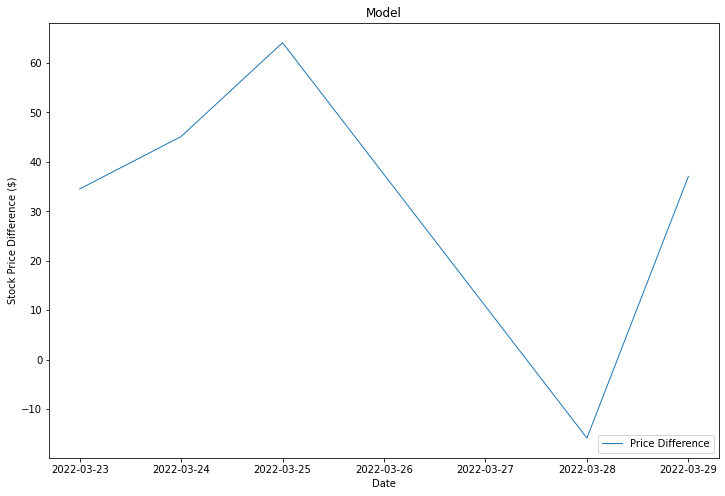

In [97]:
plt.figure(figsize=(12,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Stock Price Difference ($)')
plt.plot(price_diff[['Price Difference']], lw=1)
plt.legend(['Price Difference'],loc='lower right')
plt.show()

In [98]:

price_diff["Price Diff Percentage"] = pd.NaT
price_diff["Price Diff Percentage"] = (price_diff["Price Difference"] * 100) / price_diff["Close"]
price_diff["Buy/Sell Stock"] = pd.NaT
price_diff["Cost"] = pd.NaT
price_diff

,Close,Predicted Price,Price Difference,Price Diff Percentage,Buy/Sell Stock,Cost
Date,,,,,,
2022-03-23,999.109985,1033.622192,34.512207,3.454295,NaT,NaT
2022-03-24,1013.919983,1059.045654,45.125671,4.450615,NaT,NaT
2022-03-25,1010.640015,1074.738770,64.098755,6.342392,NaT,NaT
2022-03-28,1091.839966,1075.992798,-15.847168,-1.451419,NaT,NaT
2022-03-29,1099.569946,1136.618652,37.048706,3.369381,NaT,NaT


In [104]:
threshold = 2.0
num_stock = 0.0
for index, row in price_diff.iterrows():
  if row["Price Diff Percentage"] > threshold:
    price_diff.at[index, ["Cost"]] = row['Close']
    price_diff.at[index, ["Buy/Sell Stock"]] = 'Buy'
    num_stock = num_stock + 1
  elif row["Price Diff Percentage"] < threshold:
    price_diff.at[index, ["Cost"]] = 0.0
    price_diff.at[index, ["Buy/Sell Stock"]] = 'No Action'
price_diff

,Close,Predicted Price,Price Difference,Price Diff Percentage,Buy/Sell Stock,Cost
Date,,,,,,
2022-03-23,999.109985,1033.622192,34.512207,3.454295,Buy,999.109985
2022-03-24,1013.919983,1059.045654,45.125671,4.450615,Buy,1013.919983
2022-03-25,1010.640015,1074.738770,64.098755,6.342392,Buy,1010.640015
2022-03-28,1091.839966,1075.992798,-15.847168,-1.451419,No Action,0.0
2022-03-29,1099.569946,1136.618652,37.048706,3.369381,Buy,1099.569946


In [106]:
print("Number of stocks purchased : ",num_stock)
total_cost = price_diff['Cost'].sum()
print("Total Cost : ", total_cost)
p_n_l = (price_diff['Close'][4])*num_stock - total_cost
print("Profit or Loss : ", p_n_l)

Number of stocks purchased :  4.0
Total Cost :  4123.239929199219
Profit or Loss :  275.03985595703125
